In [84]:
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance, plot_tree

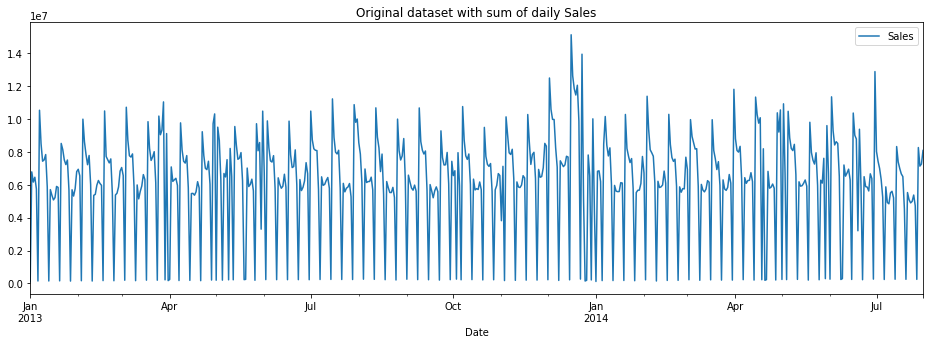

In [2]:
df = pd.read_pickle('clean_data.pkl')

main_df = pd.DataFrame(df.groupby(df['Date'])['Sales'].sum())

main_df.plot(figsize=(16,5))
plt.title('Original dataset with sum of daily Sales')
plt.show()

In [3]:
def train_val_split():
    #read in pickle
    file_path = '../data/clean_data.pkl'
    df = pd.read_pickle(file_path)
    
    #sort dataframe by Date and Store ID
    df.sort_values(by=['Date', 'Store'], ascending=True, inplace=True, ignore_index=True)
    
    #split dataset into features and target
    #k = int(df.shape[0] * relative_train)
    k = df[df['Date'] == '2014-01-31'].index.max()
    data_train = df.loc[:k, :]
    data_val = df.loc[k+1:, :]
    
    assert data_train['Date'].max() < data_val['Date'].min()
    
    #returns train and validation datasets
    return data_train, data_val

In [4]:
data_train, data_val = train_val_split()

In [5]:
def feature_engineering(df):        
    #convert state holiday categories into categoricals - yes(=1) and no(=0)
    df.loc[df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 1
    df.loc[~df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 0
    df.drop(['StateHoliday'], axis=1, inplace=True)
    
    #create seasons from date
    df.loc[df['Date'].dt.month.isin([12, 1, 2]), 'winter'] = 1
    df.loc[~df['Date'].dt.month.isin([12, 1, 2]), 'winter'] = 0
    df.loc[df['Date'].dt.month.isin([3, 4, 5]), 'spring'] = 1
    df.loc[~df['Date'].dt.month.isin([3, 4, 5]), 'spring'] = 0
    df.loc[df['Date'].dt.month.isin([6, 7, 8]), 'summer'] = 1
    df.loc[~df['Date'].dt.month.isin([6, 7, 8]), 'summer'] = 0
    df.loc[df['Date'].dt.month.isin([9, 10, 11]), 'fall'] = 1
    df.loc[~df['Date'].dt.month.isin([9, 10, 11]), 'fall'] = 0
    
    #One hot encoding for store type, assortment
    cols = ['StoreType', 'Assortment']
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df,dummies],axis=1)
        df.drop(col, axis=1, inplace=True)
    
    #convert Competition month-year into datetime
    df['D'] = 1.0     #helper column for day to be added to date
    df['Competition_open_since'] = pd.to_datetime(df.CompetitionOpenSinceYear*10000+df.CompetitionOpenSinceMonth*100+df.D, format='%Y%m%d')
    
    #determine whether Competition was active at the point in time
    comp = df['Competition_open_since'] <= df['Date']
    df.loc[comp, 'competition_active'] = 1
    df.loc[~comp, 'competition_active'] = 0
       
    #convert Promo 2 week-year into datetime
    df['helper_date'] = df.Promo2SinceYear * 1000 + df.Promo2SinceWeek * 10 + 0
    df['Promo_since'] = pd.to_datetime(df['helper_date'], format='%Y%W%w')
    
    #determine whether Promo2 was active during the month
    months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    promo_start_later = df['Promo_since'] > df['Date']

    for key, value in months.items():
        df.loc[(df['PromoInterval'].str.contains(key)) & (df['Date'].dt.month == value), 'Promo2_active'] = 1
    df.loc[promo_start_later, 'Promo2_active'] = 0
    df['Promo2_active'].fillna(0, inplace=True)
    
    #create date/datetime features
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    #delete irrelevant columns
    df.drop(['D',
            'helper_date',
            'CompetitionOpenSinceYear',
            'CompetitionOpenSinceMonth',
            'Competition_open_since',
            'Promo2SinceYear',
            'Promo2SinceWeek',
            'Promo2',
            'PromoInterval',
            'Promo_since',
            'DayOfWeek',
            ], axis=1, inplace=True)
    
    
    
    #### DELETE WHEN MATIAS IS DONE WITH DATA CLEANING###
    df = df.dropna()
    #### DELETE WHEN MATIAS IS DONE WITH DATA CLEANING###
    
    
    
    return df

In [6]:
train_enh = feature_engineering(data_train)
val_enh = feature_engineering(data_val)

In [7]:
train_enh.corr()

,Store,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,state_holiday,winter,spring,...,Assortment_c,competition_active,Promo2_active,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Store,1.000000,0.009031,0.026095,0.000262,-0.000494,-0.000127,-0.026411,0.000111,0.000072,-0.000121,...,0.003748,0.022898,-0.005883,0.000004,0.000094,0.000113,0.000017,0.000148,0.000441,0.000150
Sales,0.009031,1.000000,0.900935,0.680248,0.449026,0.071359,-0.021602,-0.255985,0.012235,-0.013424,...,0.052224,-0.038782,-0.046255,-0.453323,0.051124,0.055421,-0.015852,0.055680,0.006728,0.059358
Customers,0.026095,0.900935,1.000000,0.623036,0.320584,0.062997,-0.102190,-0.230825,-0.002719,-0.010273,...,-0.026625,-0.021225,-0.066717,-0.385040,0.034997,0.036311,-0.014216,0.036636,0.006431,0.039184
Open,0.000262,0.680248,0.623036,1.000000,0.301533,0.078004,0.008027,-0.378726,-0.012029,-0.046544,...,-0.001391,0.001626,0.004131,-0.526509,0.006350,-0.001257,-0.000278,0.001677,0.034697,0.003436
Promo,-0.000494,0.449026,0.320584,0.301533,1.000000,0.030114,0.000221,-0.038400,-0.048912,0.078284,...,0.000280,-0.004367,-0.003609,-0.383205,-0.031891,-0.027839,-0.026370,-0.029167,-0.011533,-0.009732
SchoolHoliday,-0.000127,0.071359,0.062997,0.078004,0.030114,1.000000,-0.004211,0.178417,-0.051577,-0.057415,...,-0.001494,0.001362,0.012012,-0.212225,0.103024,0.073815,-0.032492,0.073957,0.013892,0.042654
CompetitionDistance,-0.026411,-0.021602,-0.102190,0.008027,0.000221,-0.004211,1.000000,-0.000811,0.000339,-0.000658,...,0.148869,-0.018022,-0.045256,-0.001007,0.000316,0.000255,-0.000132,0.000279,0.000268,0.000369
state_holiday,0.000111,-0.255985,-0.230825,-0.378726,-0.038400,0.178417,-0.000811,1.000000,0.028192,0.101279,...,-0.002800,0.001270,0.004264,-0.073223,-0.008561,-0.011032,0.018229,-0.017051,-0.071816,-0.012678
winter,0.000072,0.012235,-0.002719,-0.012029,-0.048912,-0.051577,0.000339,0.028192,1.000000,-0.365588,...,-0.000091,-0.001130,0.027107,-0.012051,-0.358880,-0.372215,0.438861,-0.367252,-0.007094,-0.392387
spring,-0.000121,-0.013424,-0.010273,-0.046544,0.078284,-0.057415,-0.000658,0.101279,-0.365588,1.000000,...,-0.000414,-0.030360,-0.024090,0.003659,-0.349600,-0.317268,-0.160443,-0.319949,0.006604,-0.312222


<AxesSubplot:>

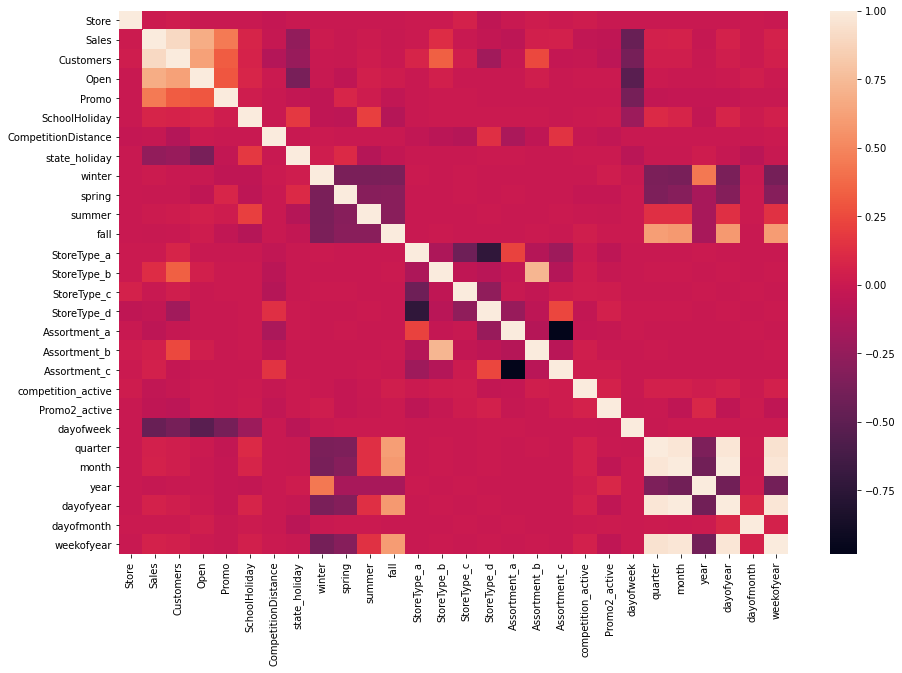

In [8]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(train_enh.corr())

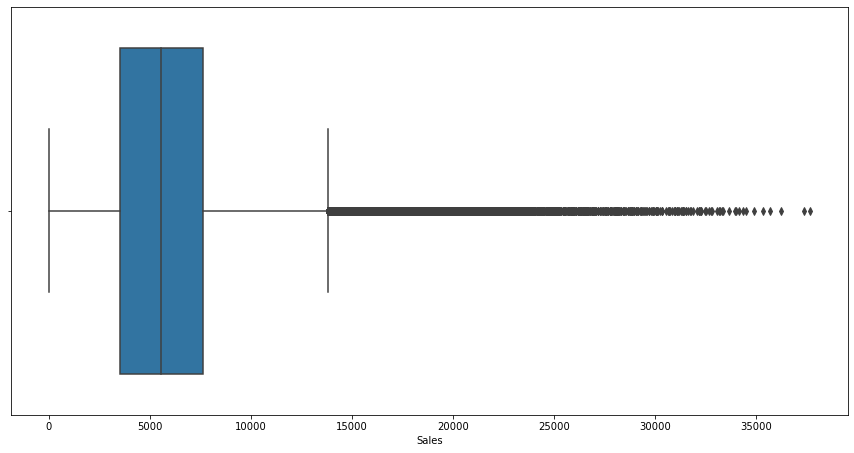

In [9]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(x=train_enh['Sales'])
plt.show()

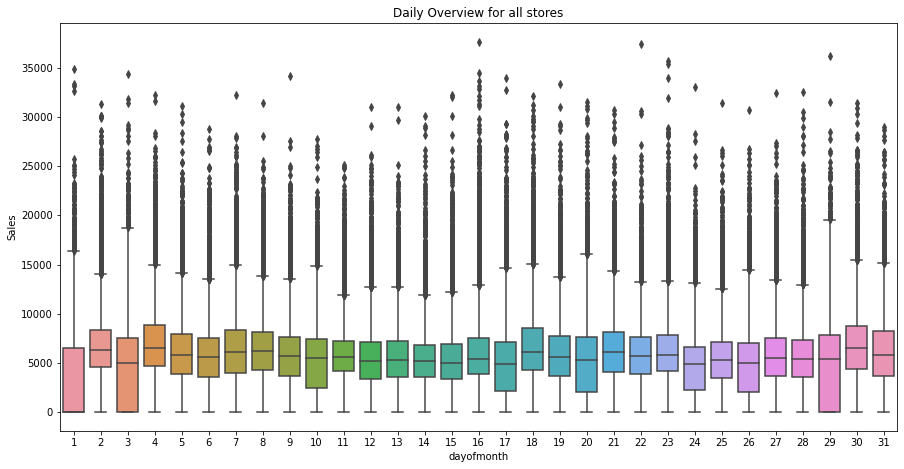

In [10]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['dayofmonth'], train_enh['Sales'])
plt.title('Daily Overview for all stores')
plt.show()

In [11]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

f = {'Sales': ['mean', 'median', 'std', q1, q2]}

train_stores = train_enh.groupby('Store').agg(f)
train_stores

Sales                                          
                mean   median          std        q1        q2
Store                                                         
1.0      4050.159420   4492.0  2067.020065   3703.00   5348.00
2.0      4028.215743   4305.0  2313.591236   2688.00   5607.50
3.0      5758.771084   5890.5  3335.472545   4102.00   8269.50
4.0      7732.265130   8749.0  4013.246615   7062.50   9968.00
5.0      3834.668605   4235.5  2449.316975   1939.00   5310.75
...              ...      ...          ...       ...       ...
1111.0   4494.168539   4791.5  2542.328408   3470.75   5969.50
1112.0   9337.677966   9484.5  5473.761554   7554.25  12679.50
1113.0   5398.643678   5897.5  2807.743217   5000.50   6869.75
1114.0  16498.154971  18903.0  8341.328084  15864.50  21249.50
1115.0   4681.956647   5159.0  2476.262140   3813.75   6151.50

[1112 rows x 5 columns]

In [12]:
train_new = train_enh.merge(train_stores, left_on='Store', right_on=train_stores.index, how='left')

/Users/nina_thumser/opt/anaconda3/envs/minicomp/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


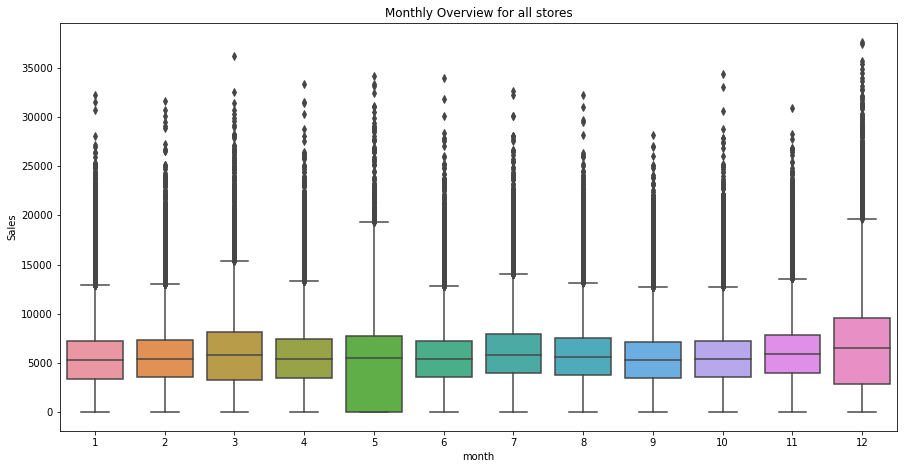

In [13]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['month'], train_enh['Sales'])
plt.title('Monthly Overview for all stores')
plt.show()

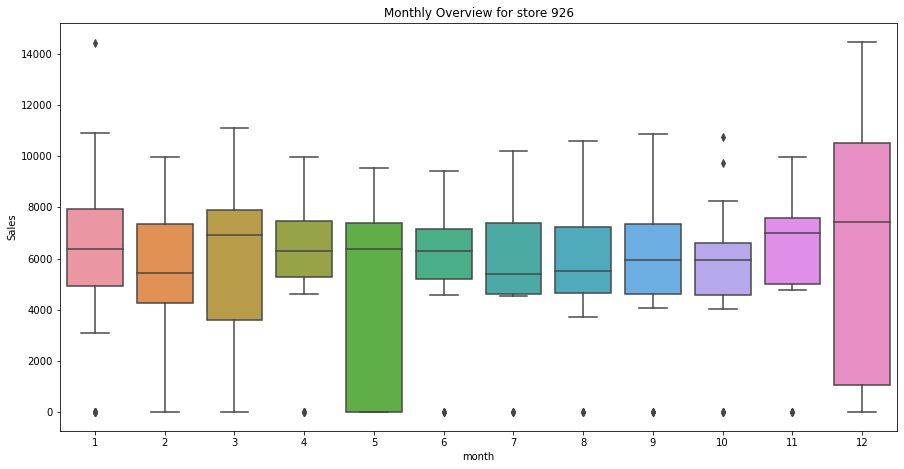

In [14]:
random_store = random.randint(1, 1115)
per_store = train_enh[train_enh['Store'] == random_store]

fig = plt.figure(figsize=(15,7.5))

sns.boxplot(per_store['month'], per_store['Sales'])
plt.title('Monthly Overview for store {}'.format(random_store))
plt.show()

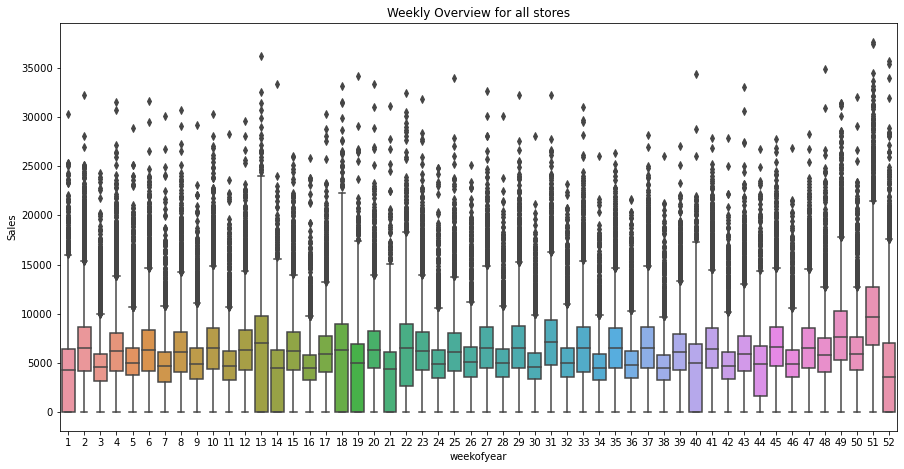

In [15]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['weekofyear'], train_enh['Sales'])
plt.title('Weekly Overview for all stores')
plt.show()

In [16]:
train_enh.to_pickle("./train.pkl")
val_enh.to_pickle("./val.pkl")

In [17]:
###START HERE AGAIN IF SOMETHING GOT STUCK###

train_enh = pd.read_pickle("./train.pkl")
val_enh = pd.read_pickle("./val.pkl")

In [18]:
def split_dataset(df, label=None):
    mask_0_sales = df['Sales'] != 0    
    df = df.loc[mask_0_sales, :]
    df.set_index('Date', inplace=True)
    X = df
    
    if label:
        X = df.drop(label, axis=1)
        y = df[label]
        
        return X, y

    return X

X_train, y_train = split_dataset(train_enh, label='Sales')
X_test, y_test = split_dataset(val_enh, label='Sales')

In [20]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [21]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [49]:
#Grid Search over n_estimators
for i in [500, 1000]:
    #Initialize XGB
    xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=i)

    xgb_reg.fit(scaled_X_train, y_train)
    predictions = xgb_reg.predict(scaled_X_test)

    result = 'n_estimators: {}'.format(i)
    print(result)
    print('-'*len(result))
    print('Mean Squared Error: {}'.format(str(mean_squared_error(np.array(y_test), predictions))))
    print('R2 Score: {}'.format(str(r2_score(np.array(y_test), predictions))))
    print('RMSPE: {}'.format(str(metric(np.array(y_test), predictions))))
    print('\n')

n_estimators: 500
-----------------
Mean Squared Error for 500 n_estimators: 242203.8274211801
R2 Score for 500 n_estimators: 0.9740929253365639
RMSPE for 500 n_estimators: 6.772622935995219
n_estimators: 1000
------------------
Mean Squared Error for 1000 n_estimators: 230167.4183759862
R2 Score for 1000 n_estimators: 0.9753803870217637
RMSPE for 1000 n_estimators: 6.636322370482753


In [48]:
#Grid Search over max_depth (n_estimators = 500)
for i in range(2, 10):
    #Initialize XGB
    xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=500, max_depth=i)

    xgb_reg.fit(scaled_X_train, y_train)
    predictions = xgb_reg.predict(scaled_X_test)
    
    result = 'n_estimators: 500 | max_depth: {}'.format(i)
    print(result)
    print('-'*len(result))
    print('Mean Squared Error: {}'.format(str(mean_squared_error(np.array(y_test), predictions))))
    print('R2 Score: {}'.format(str(r2_score(np.array(y_test), predictions))))
    print('RMSPE: {}'.format(str(metric(np.array(y_test), predictions))))
    print('\n')

max_depth: 2
------------
Mean Squared Error for 2 n_estimators: 697037.3200624055
R2 Score for 2 n_estimators: 0.9254421447987448
RMSPE for 2 n_estimators: 11.676708435458714


max_depth: 3
------------
Mean Squared Error for 3 n_estimators: 399637.53571909125
R2 Score for 3 n_estimators: 0.9572531962586124
RMSPE for 3 n_estimators: 8.684574382473912


max_depth: 4
------------
Mean Squared Error for 4 n_estimators: 305014.41033092665
R2 Score for 4 n_estimators: 0.9673744581743292
RMSPE for 4 n_estimators: 7.593854302212026


max_depth: 5
------------
Mean Squared Error for 5 n_estimators: 261163.80766078894
R2 Score for 5 n_estimators: 0.9720648912261423
RMSPE for 5 n_estimators: 7.178406256458558


max_depth: 6
------------
Mean Squared Error for 6 n_estimators: 242203.8274211801
R2 Score for 6 n_estimators: 0.9740929253365639
RMSPE for 6 n_estimators: 6.772622935995219


max_depth: 7
------------
Mean Squared Error for 7 n_estimators: 241935.81632516652
R2 Score for 7 n_estimators

In [50]:
#Grid Search over max_depth (n_estimators = 1000)
for i in range(4, 9):
    #Initialize XGB
    xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=1000, max_depth=i)

    xgb_reg.fit(scaled_X_train, y_train)
    predictions = xgb_reg.predict(scaled_X_test)
    
    result = 'n_estimators: 1000 | max_depth: {}'.format(i)
    print(result)
    print('-'*len(result))
    print('Mean Squared Error: {}'.format(str(mean_squared_error(np.array(y_test), predictions))))
    print('R2 Score: {}'.format(str(r2_score(np.array(y_test), predictions))))
    print('RMSPE: {}'.format(str(metric(np.array(y_test), predictions))))
    print('\n')

n_estimators: 1000 | max_depth: 4
---------------------------------
Mean Squared Error for 4 n_estimators: 259435.84644234285
R2 Score for 4 n_estimators: 0.9722497207590958
RMSPE for 4 n_estimators: 7.179552009311743


n_estimators: 1000 | max_depth: 5
---------------------------------
Mean Squared Error for 5 n_estimators: 237196.1883784776
R2 Score for 5 n_estimators: 0.9746285621179812
RMSPE for 5 n_estimators: 7.139467635196328


n_estimators: 1000 | max_depth: 6
---------------------------------
Mean Squared Error for 6 n_estimators: 230167.4183759862
R2 Score for 6 n_estimators: 0.9753803870217637
RMSPE for 6 n_estimators: 6.636322370482753


n_estimators: 1000 | max_depth: 7
---------------------------------
Mean Squared Error for 7 n_estimators: 235338.44371802433
R2 Score for 7 n_estimators: 0.9748272737987024
RMSPE for 7 n_estimators: 6.739201818411236


n_estimators: 1000 | max_depth: 8
---------------------------------
Mean Squared Error for 8 n_estimators: 235438.44399134

In [51]:
#Initialize XGB with n_estimates = 1000 and max_depth = 6
xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=1000, max_depth=6)

xgb_reg.fit(scaled_X_train, y_train)
predictions = xgb_reg.predict(scaled_X_test)

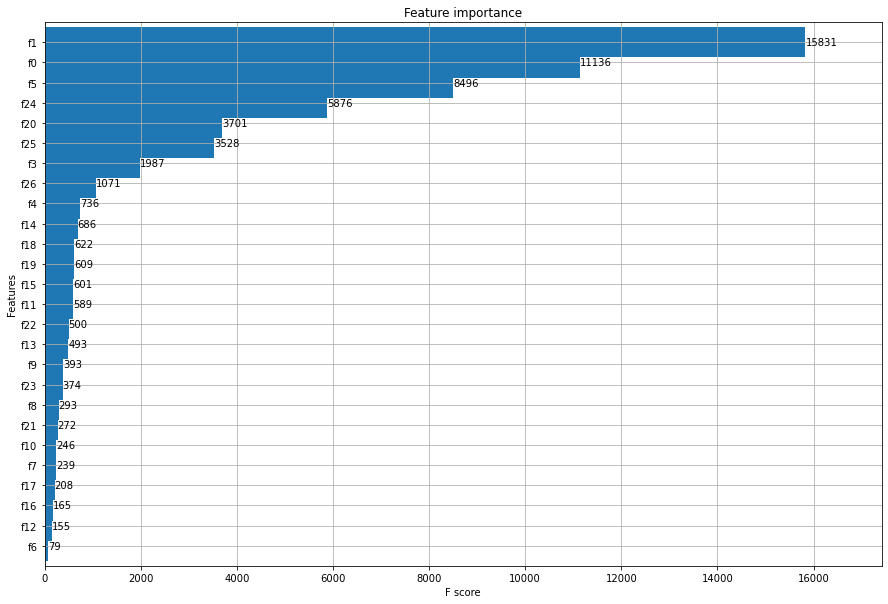

In [52]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))
_ = plot_importance(xgb_reg, ax=ax, height=1.5)

In [80]:
for index, col in enumerate(X_train.columns):
    print('f{}: {}'.format(index, col))

f0: Store
f1: Customers
f2: Open
f3: Promo
f4: SchoolHoliday
f5: CompetitionDistance
f6: state_holiday
f7: winter
f8: spring
f9: summer
f10: fall
f11: StoreType_a
f12: StoreType_b
f13: StoreType_c
f14: StoreType_d
f15: Assortment_a
f16: Assortment_b
f17: Assortment_c
f18: competition_active
f19: Promo2_active
f20: dayofweek
f21: quarter
f22: month
f23: year
f24: dayofyear
f25: dayofmonth
f26: weekofyear


In [81]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

<AxesSubplot:xlabel='Date'>

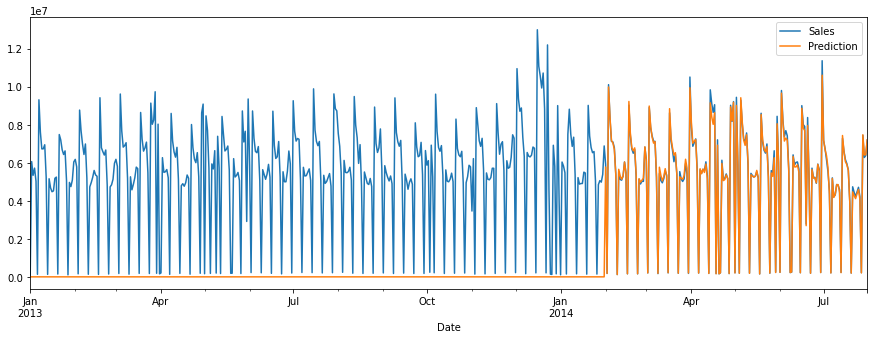

In [82]:
Xy_test['Prediction'] = predictions
df_all = pd.concat([Xy_train, Xy_test], sort=False)
df_all.groupby('Date').sum()[['Sales','Prediction']].plot(figsize=(15, 5))

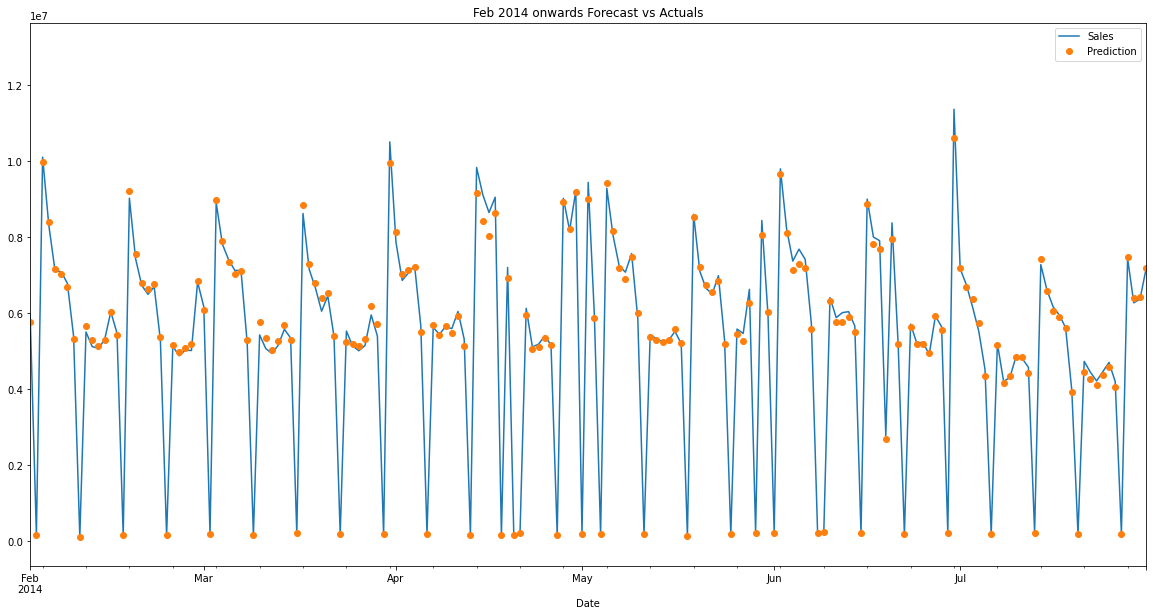

In [83]:
# Plot the forecast with the actual
ax = df_all.groupby('Date').sum()[['Sales', 'Prediction']].plot(style=['-','o'], figsize=(20, 10))
ax.set_xbound(lower='2014-02-01', upper='2014-07-31')
ax.set_title('Feb 2014 onwards Forecast vs Actuals')
plt.show()

In [38]:
xgb.__version__

'1.1.1'